In [1]:
# PTB-XL CNN + Transformer Training Notebook

import os
import ast
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, classification_report, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import torch
import torch.nn as nn

In [2]:
# Load and Preprocess Data 
ptbxl_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv")
waveform_path = Path("data/raw/ptbxl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")

df = pd.read_csv(ptbxl_path)
df['scp_codes'] = df['scp_codes'].apply(ast.literal_eval)
df['scp_keys'] = df['scp_codes'].apply(lambda x: list(x.keys()))
target_labels = ['NORM', 'AFIB', 'PVC', 'LVH', 'IMI', 'ASMI', 'LAFB', 'IRBBB']
df['scp_filtered'] = df['scp_keys'].apply(lambda x: [k for k in x if k in target_labels])
df = df[df['scp_filtered'].map(len) > 0]

mlb = MultiLabelBinarizer(classes=target_labels)
y = mlb.fit_transform(df['scp_filtered'])

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, test_idx in mskf.split(df, y):
    X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    break

afib_index = target_labels.index('AFIB')
afib_mask = y_train[:, afib_index] == 1
X_afib = X_train[afib_mask]
y_afib = y_train[afib_mask]
X_train = pd.concat([X_train] + [X_afib] * 5, ignore_index=True)
y_train = np.vstack([y_train] + [y_afib] * 5)

In [3]:
# Dataset Class
def load_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    return record.p_signal.T

class PTBXL_Dataset(Dataset):
    def __init__(self, df, labels, base_dir):
        self.df = df
        self.labels = labels
        self.base_dir = base_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['filename_lr'])
        signal = load_ecg(full_path).T
        return torch.tensor(signal, dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

train_dataset = PTBXL_Dataset(X_train, y_train, waveform_path)
test_dataset = PTBXL_Dataset(X_test, y_test, waveform_path)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, num_workers=2, pin_memory=True)

In [4]:
# Model Definition
class ECG_Transformer(nn.Module):
    def __init__(self, seq_len=5000, num_features=12, d_model=32, nhead=2, num_layers=2, num_classes=8):
        super(ECG_Transformer, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=32, out_channels=d_model, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        x = self.transformer_encoder(x)
        x = x.permute(0, 2, 1)
        x = self.global_avg_pool(x).squeeze(-1)
        return self.fc(x)

In [5]:
# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECG_Transformer().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
y_true, y_pred = [], []

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for signals, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        signals, labels = signals.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(signals)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = torch.sigmoid(outputs)
        preds[:, afib_index] = (preds[:, afib_index] > 0.3).float()
        for i in range(preds.shape[1]):
            if i != afib_index:
                preds[:, i] = (preds[:, i] > 0.5).float()
        acc = (preds == labels).float().mean().item()
        correct += acc
        total += 1
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}, Accuracy: {correct / total:.4f}")


Epoch 1/10: 100%|██████████| 2549/2549 [01:00<00:00, 42.24it/s]


Epoch 1, Loss: 0.3169, Accuracy: 0.8638


Epoch 2/10: 100%|██████████| 2549/2549 [00:52<00:00, 48.38it/s]


Epoch 2, Loss: 0.2263, Accuracy: 0.9064


Epoch 3/10: 100%|██████████| 2549/2549 [00:52<00:00, 48.37it/s]


Epoch 3, Loss: 0.1881, Accuracy: 0.9240


Epoch 4/10: 100%|██████████| 2549/2549 [00:52<00:00, 48.14it/s]


Epoch 4, Loss: 0.1701, Accuracy: 0.9309


Epoch 5/10: 100%|██████████| 2549/2549 [00:55<00:00, 45.84it/s]


Epoch 5, Loss: 0.1573, Accuracy: 0.9361


Epoch 6/10: 100%|██████████| 2549/2549 [00:54<00:00, 46.42it/s]


Epoch 6, Loss: 0.1466, Accuracy: 0.9412


Epoch 7/10: 100%|██████████| 2549/2549 [00:56<00:00, 45.46it/s]


Epoch 7, Loss: 0.1391, Accuracy: 0.9442


Epoch 8/10: 100%|██████████| 2549/2549 [00:55<00:00, 45.61it/s]


Epoch 8, Loss: 0.1326, Accuracy: 0.9466


Epoch 9/10: 100%|██████████| 2549/2549 [00:56<00:00, 45.16it/s]


Epoch 9, Loss: 0.1270, Accuracy: 0.9495


Epoch 10/10: 100%|██████████| 2549/2549 [00:54<00:00, 46.88it/s]

Epoch 10, Loss: 0.1230, Accuracy: 0.9515


In [6]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for signals, labels in test_loader:
        signals, labels = signals.to(device), labels.to(device)
        outputs = model(signals)
        y_true.append(labels.cpu().numpy())
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())

y_true = np.vstack(y_true)
y_pred = np.vstack(y_pred)

In [7]:
# Save predictions for ROC comparison
torch.save(model.state_dict(), "transformer_cnn_model.pt")
np.save("y_true_transformer_cnn.npy", y_true)
np.save("y_pred_transformer_cnn.npy", y_pred)

In [8]:
# Apply threshold for AFIB and generate report
thresholds = np.full(y_pred.shape[1], 0.5)
thresholds[1] = 0.3
preds = (y_pred > thresholds).astype(int)

print("Classification Report:")
print(classification_report(y_true, preds, target_names=mlb.classes_))
print("Macro ROC-AUC:", roc_auc_score(y_true, y_pred, average='macro'))

Classification Report:
              precision    recall  f1-score   support

        NORM       0.85      0.96      0.90      1906
        AFIB       0.67      0.94      0.78       303
         PVC       0.79      0.76      0.77       229
         LVH       0.81      0.58      0.68       427
         IMI       0.83      0.52      0.64       537
        ASMI       0.85      0.72      0.78       473
        LAFB       0.78      0.87      0.82       325
       IRBBB       0.66      0.65      0.66       223

   micro avg       0.81      0.81      0.81      4423
   macro avg       0.78      0.75      0.75      4423
weighted avg       0.82      0.81      0.80      4423
 samples avg       0.83      0.84      0.82      4423

Macro ROC-AUC: 0.9650186281589936


/users/PLS0151/nicholaskanos/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


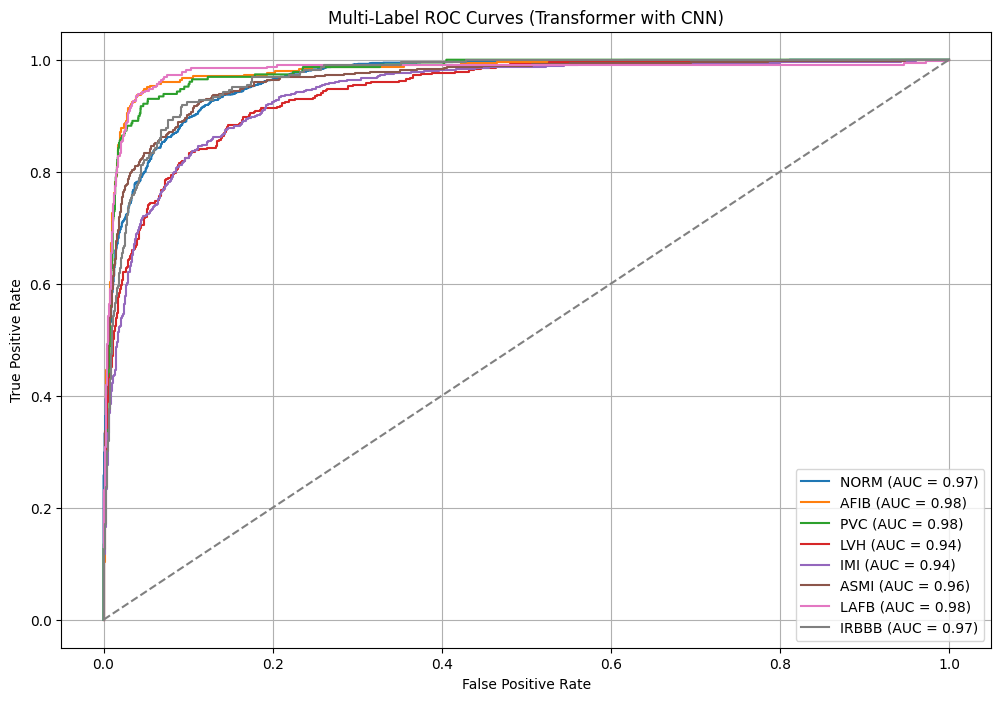

In [9]:
# Plot ROC Curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Label ROC Curves (Transformer with CNN)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

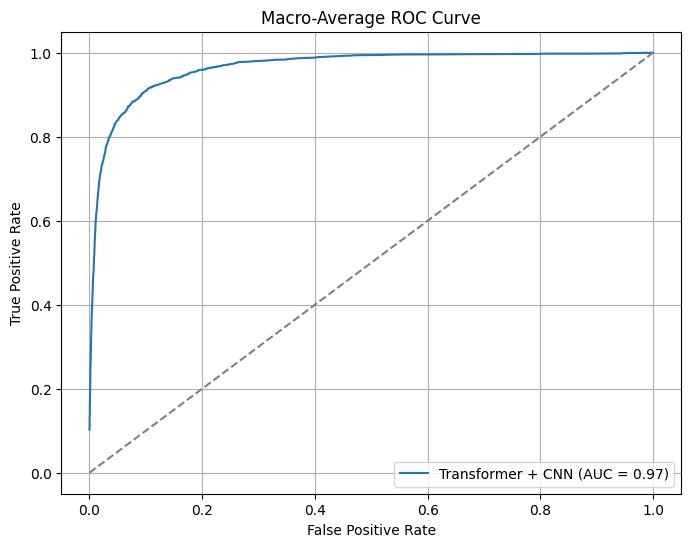

In [10]:
# Macro-Average ROC
def compute_macro_roc(y_true, y_pred):
    n_classes = y_true.shape[1]
    fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
    for i in range(n_classes):
        fpr_dict[i], tpr_dict[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
    all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
    mean_tpr /= n_classes
    macro_auc = auc(all_fpr, mean_tpr)
    return all_fpr, mean_tpr, macro_auc

fpr, tpr, macro_auc = compute_macro_roc(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Transformer + CNN (AUC = {macro_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('Macro-Average ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [11]:
np.save("y_true_transformer_CNN.npy", y_true)
np.save("y_pred_transformer_CNN.npy", y_pred)